In [1]:
import platform
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')
# sns.set_theme(style="ticks", palette="pastel")
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:  # Mac or other systems
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# normalize all waveforms to the range [-1, 1] for better classification
df['flux_density'] = df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)
df.head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
0,1,25,50030,1997.95525,正弦波,"[0.007229411718616685, 0.013356668196946586, 0..."


In [2]:
df.iloc[5242].values[-1][0]

-0.8445677992948601

In [3]:
assert len(df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == True]) == 0

In [4]:
df.type_material.unique()

array(['1', '2', '3', '4'], dtype=object)

# 问题一： 励磁波形分类

输入一个长度为1024的序列，输出一个类别（正弦波0、三角波1、梯形波2）

In [5]:
df[df['type_waveform'] == '梯形波'].head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
2370,1,25,50060,12568.70593,梯形波,"[-0.533595069356785, -0.5221503770225163, -0.5..."


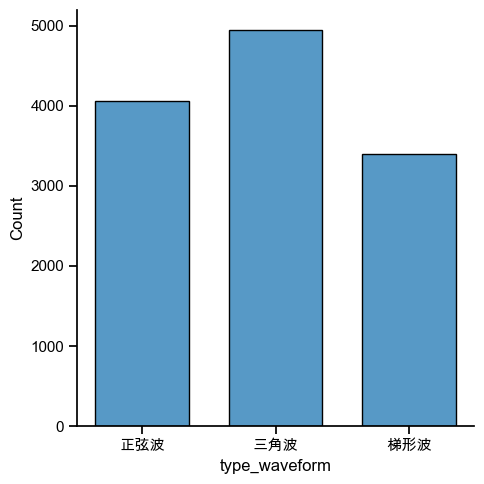

In [6]:
sns.displot(df['type_waveform'], shrink=0.7)

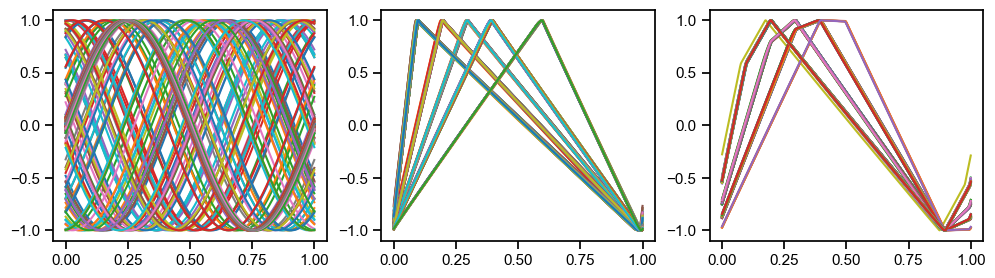

In [7]:
# iterate over the range with a step of 10, ensuring the index is within bounds
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
xs = np.linspace(0, 1, 1024)
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    for i in range(1, min(10000, len(df[df['type_waveform'] == type_waveform])), 12):
        ax.plot(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[i])
plt.savefig('figures/waveform.png', dpi=500, bbox_inches='tight')

## 尝试一：傅立叶变换、时频谱图

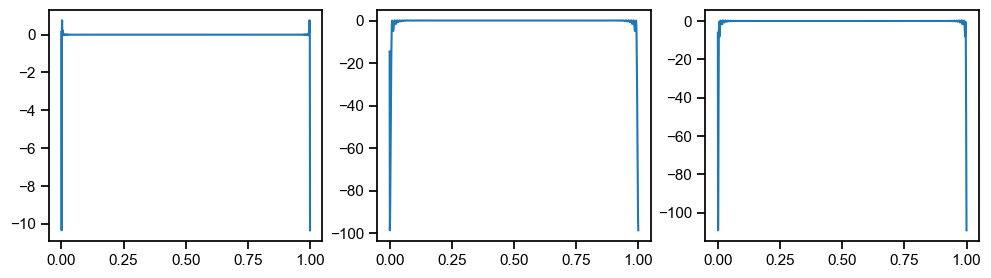

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    ax.plot(xs, np.fft.fft(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1]))

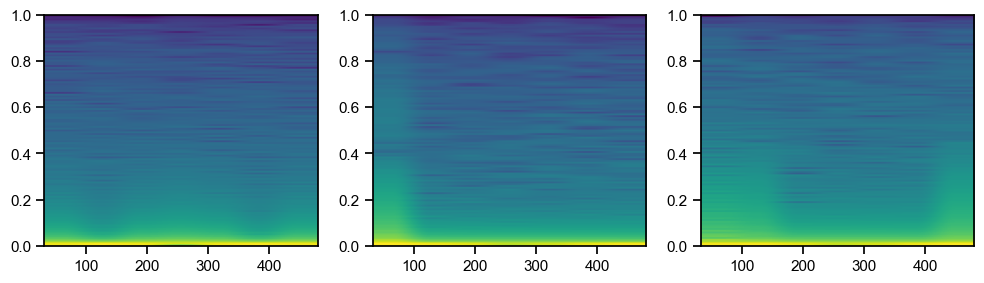

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    ax.specgram(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1])

## 尝试二：斜率变化、拐点情况（特征工程）

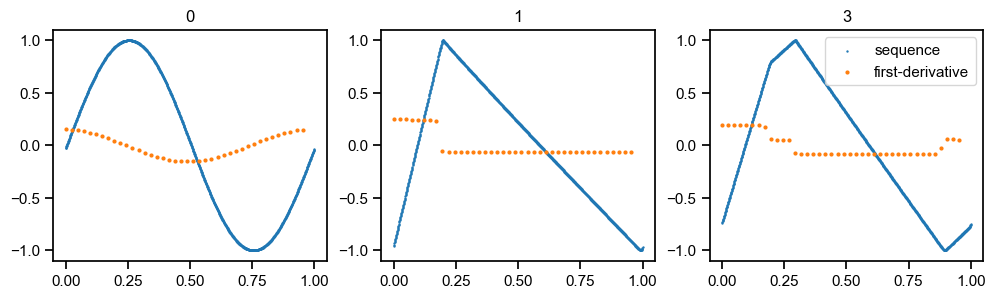

In [10]:
def break_counter(sequence, step=25, eps=0.05, verbose=False):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    # second_derivative = np.diff(first_derivative)
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 2:
                pivots.append(j)
    if verbose:
        print(pivots)
    return len(pivots)


fig, axes = plt.subplots(1, 3, figsize=(12, 3))
step = 25
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    sequence = df[df['type_waveform'] == type_waveform].sample(1)['flux_density'].values[0]
    first_derivative = np.diff(sequence[::step])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    # count the number of the "change" of the first_derivative is bigger than eps
    ax.set_title(f'{break_counter(sequence, step=step, eps=0.075)}')
plt.legend()
plt.show()

In [11]:
df.iloc[8603]

type_material                                                    3
temp                                                            25
freq                                                         79500
core_loss                                               489739.917
type_waveform                                                  梯形波
flux_density     [-0.8825725868071932, -0.8765264220835679, -0....
Name: 8603, dtype: object

In [12]:
flag = False

for _ in tqdm(range(10_000)):
    sstep, eeps = 25, 0.05
    sequence = df[df['type_waveform'] == '正弦波'].sample(1)['flux_density'].values[0]
    assert break_counter(sequence, step=sstep, eps=eeps) == 0

    record = df[df['type_waveform'] == '三角波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [1, 2]:
        flag = True
        break

    record = df[df['type_waveform'] == '梯形波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [3, 4]:
        flag = True
        break

if flag:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    print(break_count, record)
    ax.scatter(xs, sequence, s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, s=4)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

## 测试

特别把附件二中样本序号为：1, 5, 15, 25, 35, 45, 55, 65, 75, 80 的分类结果，以表格形式呈现在论文正文中。

In [13]:
test_df = pd.read_excel('dataset/附件二（测试集）.xlsx')
test_df.rename(columns={'0（磁通密度B，T）': 0}, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 4:].apply(
    lambda r: r.values, axis=1)
test_df.drop(columns=[i for i in range(1024)], inplace=True)

# N.B. normalize all waveforms to the range [-1, 1]
# in accordance with the training data
test_df['flux_density'] = test_df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)
test_df.head()

,序号,温度，oC,频率，Hz,磁芯材料,flux_density
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0...."
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0...."
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0...."
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0...."
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0...."


In [14]:
type2name = {1: '正弦波', 2: '三角波', 3: '梯形波'}
counter2type = {0: 1, 1: 2, 2: 2, 3: 3, 4: 3, }

test_df['励磁波形'] = test_df.apply(lambda x: counter2type[break_counter(x['flux_density'], step=25, eps=0.05)], axis=1)
test_df.head()
test_df.to_excel('test_df.xlsx', index=False)

In [15]:
test_df

,序号,温度，oC,频率，Hz,磁芯材料,flux_density,励磁波形
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0....",2
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0....",2
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0....",2
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0....",2
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0....",2
...,...,...,...,...,...,...
75,76,25,89080,材料4,"[-0.013734466683050561, -0.007562068208353145,...",1
76,77,25,251170,材料4,"[0.004685617520659546, 0.010871439782496495, 0...",1
77,78,50,79470,材料4,"[0.012765596666491907, 0.01893978327588175, 0....",1
78,79,50,251170,材料4,"[-0.03090998333697459, -0.024745700178830488, ...",1


In [16]:
sequence = test_df.iloc[-1]['flux_density']
len(sequence)

1024

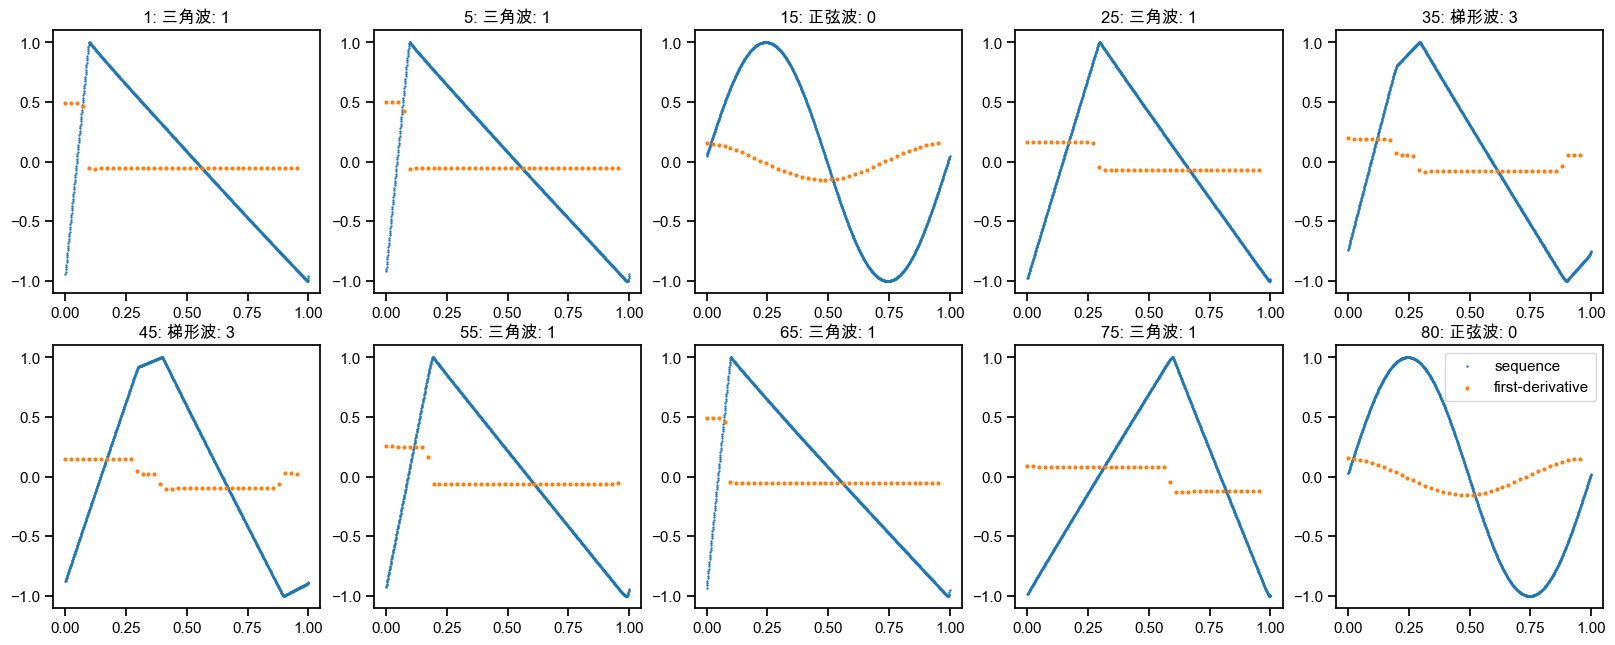

In [17]:
xs = np.linspace(0, 1, 1024)
fig, axes = plt.subplots(2, 5, figsize=(20, 7.5))
for i, ax in zip([1, 5, 15, 25, 35, 45, 55, 65, 75, 80], axes.flatten()):
    sequence = test_df.iloc[i-1]['flux_density']
    sequence = np.array([float(x) for x in sequence])  # convert each element to float and then to numpy array
    first_derivative = np.diff(sequence[::25])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    ax.set_title(f'{i}: {type2name[test_df.iloc[i-1]["励磁波形"]]}: {break_counter(sequence)}')
plt.legend()
plt.savefig('figures/p1.pdf', bbox_inches='tight')

## 后记：参数设定


In [18]:
set_step = [5, 8, 16, 25, 40, 64, 128]
set_eps = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

## 阈值的选择

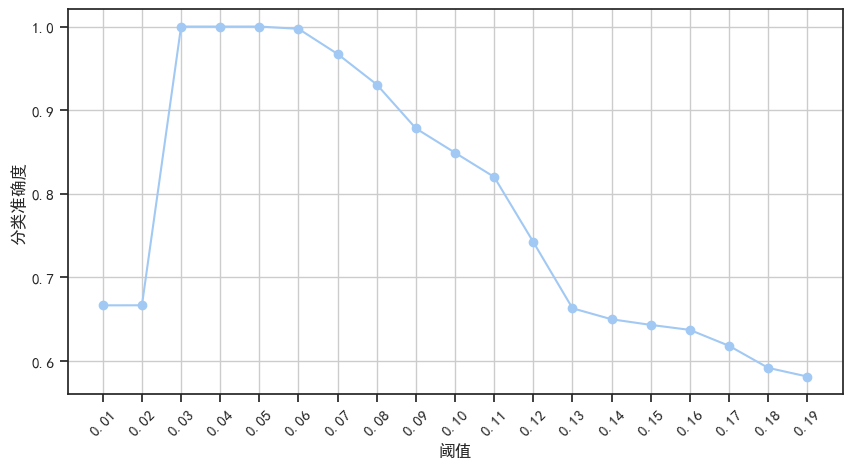

In [25]:
import platform
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_theme(style="ticks", palette="pastel")
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:  # Mac or other systems
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# normalize all waveforms to the range [-1, 1] for better classification
df['flux_density'] = df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)

def break_counter(sequence, step=25, eps=0.05, verbose=False):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    # second_derivative = np.diff(first_derivative)
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 2:
                pivots.append(j)
    if verbose:
        print(pivots)
    return len(pivots)

def evaluate_thresholds(thresholds, step=25):
    accuracies = []
    
    for eps in thresholds:
        correct_count = 0
        total_count = 0
        
        for _ in range(10_000):
            # 评估正弦波
            sequence = df[df['type_waveform'] == '正弦波'].sample(1)['flux_density'].values[0]
            if break_counter(sequence, step=step, eps=eps) == 0:
                correct_count += 1
            
            # 评估三角波
            record = df[df['type_waveform'] == '三角波'].sample(1)
            sequence = record.iloc[0, -1]
            break_count = break_counter(sequence, step=step, eps=eps)
            if break_count in [1, 2]:
                correct_count += 1
            
            # 评估梯形波
            record = df[df['type_waveform'] == '梯形波'].sample(1)
            sequence = record.iloc[0, -1]
            break_count = break_counter(sequence, step=step, eps=eps)
            if break_count >= 3:
                correct_count += 1
            
            total_count += 3  # 每个波形类型各计一次
        
        # 计算准确度
        accuracy = correct_count / total_count
        accuracies.append(accuracy)
    
    return accuracies

# 定义不同的阈值
thresholds = np.arange(0.01, 0.2, 0.01)
accuracies = evaluate_thresholds(thresholds)

# 绘制准确度与阈值的关系图
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('阈值')
plt.ylabel('分类准确度')
plt.grid()
plt.xticks(thresholds, rotation=45)
plt.show()

## 测试集数据分布结果

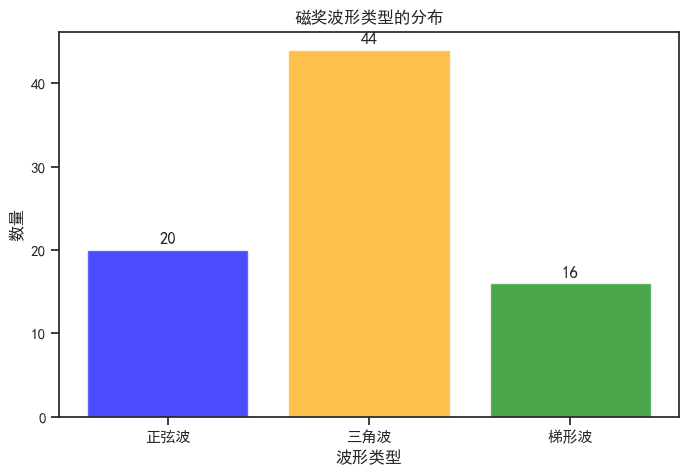

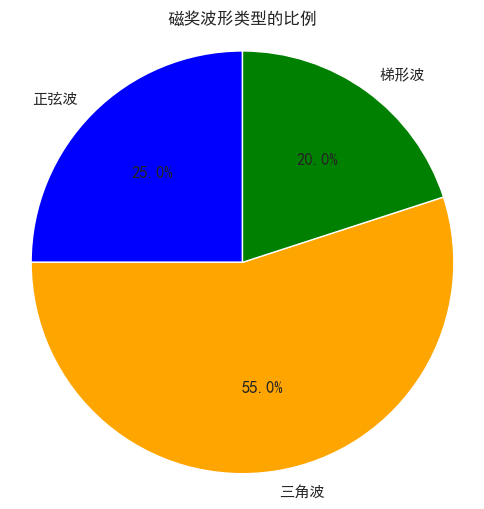

In [30]:

# 其中 1 表示正弦波，2 表示三角波，3 表示梯形波

# 统计各个波形类型的数量
waveform_counts = test_df['励磁波形'].value_counts().sort_index()

# 直方图
plt.figure(figsize=(8, 5))
bars = plt.bar(waveform_counts.index, waveform_counts.values, color=['blue', 'orange', 'green'], alpha=0.7)

# 在每个柱子上标注对应的数量
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.xlabel('波形类型')
plt.ylabel('数量')
plt.title('磁奖波形类型的分布')
plt.xticks([1, 2, 3], ['正弦波', '三角波', '梯形波'])
plt.show()

# 饼图
plt.figure(figsize=(6, 6))
labels = ['正弦波', '三角波', '梯形波']
plt.pie(waveform_counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'orange', 'green'], startangle=90)
plt.title('磁奖波形类型的比例')
plt.axis('equal')  # 使饼图为圆形
plt.show()

